In [1]:
import pyart 
import numpy as np
import pandas as pd
import warnings
import xarray
from siphon.simplewebservice.iastate import IAStateUpperAir
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=RuntimeWarning)
from datetime import datetime
import glob, os
import auto_filter,snr_noise,attenuation,calc_kdp,tools,retrieval,echo_classification
import gridrad_homeyer
from skimage import measure


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Setting relevant paths
#-------------------------------------------------------------------------------------------------
input_gridpath = '/scra6/ft21894/radartrunk/0706/grid/0530-0700/'
radargridlist = sorted(glob.glob(input_gridpath+'*.nc')) #KABR_KFSD
input_gridrad = sorted(glob.glob('/scra6/ft21894/radartrunk/NEXRAD_mosaic/0620_plot/'+'*.nc'))
#Bowman, K. P., and C. R. Homeyer. 2017. (cite:https://rda.ucar.edu/datasets/ds841.0/)

# Read in grid files and save data time
#-------------------------------------------------------------------------------------------------
#base = pyart.io.read_grid(radargridlist[2]) #0620b:10 0701:4 0706:0,8 0617:11;7,19 (LNX),
#base.fields.keys()
#dt = datetime.strptime(base.time['units'][-20:], '%Y-%m-%dT%H:%M:%SZ')

In [27]:
from copy import deepcopy
convstrat = xarray.open_dataset('/scra6/ft21894/radartrunk/0701/KOAX_20150701054331_20150701065258_convstrat.nc')
eclass = convstrat['steiner_eclass'][10,:,:]
ref = []
for i in range(22): #0720b:15
    #print(i)
    base = pyart.io.read_grid(radargridlist[i])
    ref.append(deepcopy(base.fields['reflectivity']['data'][2:,:,:]))
    del base
#eclass3d = []
#for j in range(13):
 #   tmp = convstrat['steiner_eclass'][j,:,:]
 #   eclass3d.append(np.broadcast_to(tmp, (39, *tmp.shape)))

/scra6/ft21894/anaconda3/lib/python3.7/site-packages/pyart/io/grid_io.py:107: UserWarning: Field alt skipped due to incorrect shape (1,)
  % (field, bad_shape))
/scra6/ft21894/anaconda3/lib/python3.7/site-packages/pyart/io/grid_io.py:107: UserWarning: Field lat skipped due to incorrect shape (1,)
  % (field, bad_shape))
/scra6/ft21894/anaconda3/lib/python3.7/site-packages/pyart/io/grid_io.py:107: UserWarning: Field lon skipped due to incorrect shape (1,)
  % (field, bad_shape))


IndexError: list index out of range

In [4]:
refc = deepcopy(ref)
#for i in range(23): #0617:38
#    refc[i][eclass3d[i]<2]=-9999
#    refc[i][refc[i]<15] = -9999

def clean_beneath(array=None,sizearray=refc[0][:]):
    echo_top = np.zeros_like(refc[0][0,:,:])
    for i in range(sizearray.shape[0]):
        for j in range(sizearray.shape[1]):
            tmp = np.asarray(array[:,i,j])
            if all(np.isnan(tmp)) is True:
                echo_top[i,j] = np.nan
            #echo_top[i,j] = np.min(np.where(np.isnan(array[:,i,j])))-1
            else:
                temptemp = next((idx for idx, val in np.ndenumerate(np.asarray(tmp)) if val!=-9999),0)
                if isinstance(temptemp,tuple):
                    temptemp = temptemp[0]
                echo_top[i,j] = temptemp
    return echo_top
    
def echo_top_index(array=None,sizearray=refc[0][0,:,:]):
    echo_top = np.zeros_like(refc[0][0,:,:])
    for i in range(sizearray.shape[0]):
        for j in range(sizearray.shape[1]):
            tmp = np.asarray(array[:,i,j])
            if all(np.isnan(tmp)) is True:
                echo_top[i,j] = np.nan
            #echo_top[i,j] = np.min(np.where(np.isnan(array[:,i,j])))-1
            else:
                temptemp = next((idx for idx, val in np.ndenumerate(np.asarray(tmp)) if val==-9999),0)
                if isinstance(temptemp,tuple):
                    temptemp = temptemp[0]
                echo_top[i,j] = temptemp
    return echo_top

def echo_top_h(index=None,height=None,sizearray=refc[0][0,:,:]):
    echo_toph = np.zeros_like(sizearray)
    for i in range(sizearray.shape[0]):
        for j in range(sizearray.shape[1]):
            tmp=index[i,j]
            if np.isnan(tmp):
                echo_toph[i,j] = np.nan
            else:
                echo_toph[i,j] = base.z['data'][int(tmp)]
def add_beneath(index=None,array=None):
    from copy import deepcopy
    arrayf = deepcopy(array)
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if index[i,j]==0:
                continue
            else:
                arrayf[0:int(index[i,j])-1,i,j] = arrayf[int(index[i,j]),i,j]
    return arrayf

In [ ]:
clean_refc = []
for i in (range(15)):
    print(i)
    clean_refc.append(clean_beneath(array=refc[i]))
    
clean_refcc = []
for i in (range(15)):
    print(i)
    clean_refcc.append(add_beneath(index=clean_refc[i],array=refc[i]))

In [5]:
from tqdm import tqdm
echo_topi = []
for i in (range(22)):
    print(i)
    echo_topi.append(echo_top_index(refc[i])+2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


### Storm motion vector

In [4]:
def polygonize(array=None,amplitude_filter=None,size_filter=None,method='centroid',amplitude_num=None):
    """
    (1) Use scikit-image to identify contours
    (2) Use shapely to calculate centroid coordinate
    """
    from shapely.geometry import Polygon
    if amplitude_num is None:
        contours = measure.find_contours(array,np.nanpercentile(array[array>0],amplitude_filter))
    else:
        contours = measure.find_contours(array,amplitude_num)
    
    dict_area = []
    for contour in contours:
        if len(contour)<3: #Filter small objects
            dict_area.append(0)
        else:
            polygon=Polygon(contour)
            dict_area.append(polygon.area)
            
    large_objectindex = np.where(np.asarray(dict_area)>np.percentile(np.asarray(dict_area),size_filter))
    centroid_obj,centroid_objkdp = [],[]
    for obj in np.squeeze(large_objectindex):
        polygon_temp = Polygon(contours[obj])
        if method=='centroid':
            centroid_obj.append(polygon_temp.centroid.coords)
        elif method=='representative_point':
            centroid_obj.append(polygon_temp.representative_point().coords)
    return contours,centroid_obj,dict_area

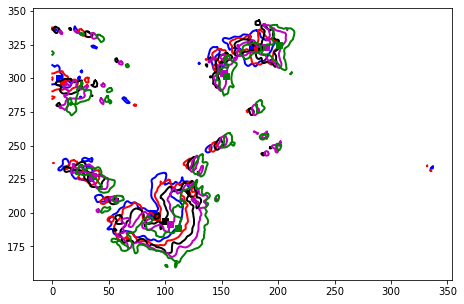

In [7]:
#del cntr,cntrd
cntr,cntrd = [],[]
for i in range(5):
    cntr_reft,cntrd_reft,_ = polygonize(ref[i][2,:,:],85,90)
    cntr.append(cntr_reft)
    cntrd.append(cntrd_reft)

fig = plt.figure(figsize=(7.5,5))
# plot super resolution reflectivity
ax = fig.add_subplot(111)
#a = ax.pcolormesh(np.ma.masked_equal(refc[0][2,:,:],0), cmap='viridis',vmin=0,vmax=60)
#plt.colorbar(a)
c=['b','r','k','m','g']
for i in range(5):
    cntr_reft,cntrd_reft=cntr[i],cntrd[i]
    for contour in cntr_reft:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color=c[i])
    for obj in cntrd_reft:
        ax.plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color=c[i],marker='s')
#plt.ylim(100,150)
#plt.xlim(30,80)
plt.show()

In [8]:
tmp = [((obj.xy[1][0]-cntrd[0][0].xy[1][0])**2+(obj.xy[0][0]-cntrd[0][0].xy[0][0])**2)**(0.5) for obj in cntrd[4]]
x_dist,y_dist = cntrd[4][np.asarray(tmp).argmin()].xy[1][0]-cntrd[0][0].xy[1][0],\
cntrd[4][np.asarray(tmp).argmin()].xy[0][0]-cntrd[0][0].xy[0][0] #x,y
storm_moang=np.arctan(y_dist/x_dist)
storm_mospd=np.sqrt(x_dist**2+y_dist**2)*1000/\
((parse_time_from_filename(radargridlist[4])-parse_time_from_filename(radargridlist[0])).total_seconds())

### Polarimetric separation vectors

In [3]:
def polygonize2(array=None,amplitude_filter=None,size_filter=None,method='centroid',amplitude_num=None):
    """
    (1) Use scikit-image to identify contours
    (2) Use shapely to calculate centroid coordinate
    """
    from shapely.geometry import Polygon
    if amplitude_num is None:
        contours = measure.find_contours(array,np.nanpercentile(array[array>0],amplitude_filter))
    else:
        contours = measure.find_contours(array,amplitude_num)
    
    dict_area = []
    for contour in contours:
        if len(contour)<3: #Filter small objects
            dict_area.append(0)
        else:
            polygon=Polygon(contour)
            dict_area.append(polygon.area)
            
    large_objectindex = np.where(np.asarray(dict_area)>np.percentile(np.asarray(dict_area),size_filter))
    centroid_obj,centroid_objkdp = [],[]
    for obj in np.squeeze(large_objectindex):
        polygon_temp = Polygon(contours[obj])
        if method=='centroid':
            centroid_obj.append(polygon_temp.centroid.coords)
        elif method=='representative_point':
            centroid_obj.append(polygon_temp.representative_point().coords)
    return contours,centroid_obj,dict_area

In [116]:
from scipy.ndimage import gaussian_filter
base = pyart.io.read_grid(radargridlist[17])
#eclass = convstrat['steiner_eclass'][0,:,:]
conv_zdr = gaussian_filter(base.fields['zdr_acorr']['data'][4,:,:],0.77)
conv_zdr[gaussian_filter(base.fields['cross_correlation_ratio']['data'][4,:,:],0.77)<0.95] = 0
conv_zdr[gaussian_filter(base.fields['reflectivity']['data'][4,:,:],0.77)<30] = 0
conv_kdp = gaussian_filter(base.fields['KDP']['data'][4,:,:],0.67)
conv_kdp[gaussian_filter(base.fields['cross_correlation_ratio']['data'][4,:,:],0.67)<0.95] = 0
conv_kdp[gaussian_filter(base.fields['reflectivity']['data'][4,:,:],0.67)<30] = 0

cntr_zdrt,cntrd_zdrt,_ = polygonize2(array=conv_zdr[:,:],amplitude_filter=92,
                                     size_filter=75,method='centroid',amplitude_num=None)
cntr_kdpt,cntrd_kdpt,_ = polygonize2(array=conv_kdp[:,:],amplitude_filter=93,
                                     size_filter=60,method='centroid',amplitude_num=None)

/scra6/ft21894/anaconda3/lib/python3.7/site-packages/pyart/io/grid_io.py:107: UserWarning: Field alt skipped due to incorrect shape (1,)
  % (field, bad_shape))
/scra6/ft21894/anaconda3/lib/python3.7/site-packages/pyart/io/grid_io.py:107: UserWarning: Field lat skipped due to incorrect shape (1,)
  % (field, bad_shape))
/scra6/ft21894/anaconda3/lib/python3.7/site-packages/pyart/io/grid_io.py:107: UserWarning: Field lon skipped due to incorrect shape (1,)
  % (field, bad_shape))


In [117]:
from copy import deepcopy
dist_vect = []
for objz in cntrd_zdrt:
    tmp = [((obj.xy[1][0]-objz.xy[1][0])**2+(obj.xy[0][0]-objz.xy[0][0])**2)**(0.5) for obj in cntrd_kdpt]
    dist_vect.append(tmp)

cntr_zdrtc,cntrd_zdrtc = deepcopy(cntr_zdrt),deepcopy(cntrd_zdrt)
for index,value in enumerate(dist_vect):
    if all(element>25 for element in value):
        cntr_zdrtc[index]=np.nan
        cntrd_zdrtc[index]=np.nan
        dist_vect[index] = np.nan

zdrkdp_xdist,zdrkdp_ydist = [],[]
for index,zdrc in enumerate(cntrd_zdrtc):
    if np.isnan(zdrc).any():
        zdrkdp_xdist.append(np.nan)
        zdrkdp_ydist.append(np.nan)
    else:
        zdrc_x,zdrc_y = zdrc[0][1],zdrc[0][0]
        tmp_x,tmp_y = [(-obj.xy[1][0]+zdrc_x) for obj in cntrd_kdpt],\
        [(-obj.xy[0][0]+zdrc_y) for obj in cntrd_kdpt]
        zdrkdp_xdist.append(tmp_x)
        zdrkdp_ydist.append(tmp_y)

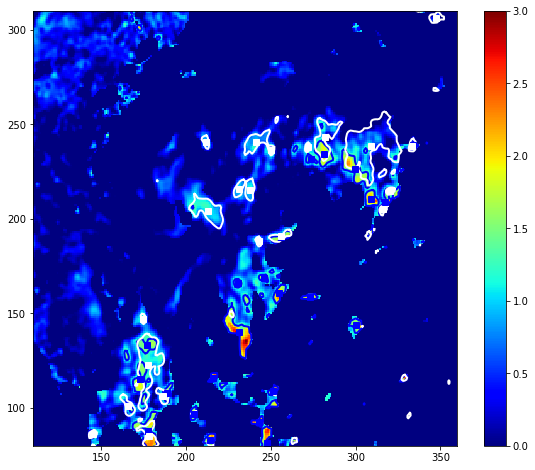

In [118]:
fig = plt.figure(figsize=(9.5,8))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
#echo_topih = np.zeros_like(echo_topi[0])
#for i in range(echo_topi[4].shape[0]):
#    for j in range(echo_topi[4].shape[1]):
#        temp = base.z['data'][int(np.asarray(echo_topi[0])[i,j])]
#        if isinstance(temp,tuple):
#            temp = temp[0]
#            echo_topih[i,j] = int(temp)
#        else:
#            echo_topih[i,j] = int(temp)
a = ax.pcolormesh(conv_zdr, cmap='jet',vmin=0,vmax=3)
plt.colorbar(a)
c = ['r','b','g','k','y','m','chocolate','w','gray']
for contour in cntr_zdrt:
    if np.isnan(contour).all():
        continue
    else:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='b')
for contour in cntr_kdpt:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='w')
for i,obj in enumerate(cntrd_zdrt):
    if np.isnan(obj).all():
        continue
    else:
        ax.plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color='b',marker='s')
for i,obj in enumerate(cntrd_kdpt):
    ax.plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color='w',marker='s')
#ax.plot(list(circle.exterior.coords.xy[0]), list(circle.exterior.coords.xy[1]), linewidth=1,color='b')
#ax.pcolormesh(mask, alpha=.25, cmap='gray')
#patch = PathPatch(polypath, facecolor='g', alpha=.5)
#patch2 = PathPatch(polypath2, facecolor='b', alpha=.5)
#ax.add_patch(patch)
#ax.add_patch(patch2)
plt.xlim(70+40,320+40)
plt.ylim(80,310)
plt.show()

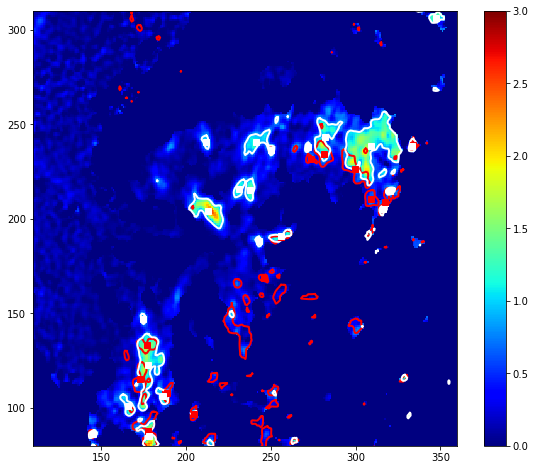

In [119]:
fig = plt.figure(figsize=(9.5,8))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
#echo_topih = np.zeros_like(echo_topi[0])
#for i in range(echo_topi[4].shape[0]):
#    for j in range(echo_topi[4].shape[1]):
#        temp = base.z['data'][int(np.asarray(echo_topi[0])[i,j])]
#        if isinstance(temp,tuple):
#            temp = temp[0]
#            echo_topih[i,j] = int(temp)
#        else:
#            echo_topih[i,j] = int(temp)
a = ax.pcolormesh(conv_kdp, cmap='jet',vmin=0,vmax=3)
plt.colorbar(a)
c = ['r','b','g','k','y','m','chocolate','w','gray']
for contour in cntr_zdrt:
    if np.isnan(contour).all():
        continue
    else:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='r')
for contour in cntr_kdpt:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='w')
for i,obj in enumerate(cntrd_zdrtc):
    if np.isnan(obj).all():
        continue
    else:
        ax.plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color='r',marker='s')
for i,obj in enumerate(cntrd_kdpt):
    ax.plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color='w',marker='s')
#ax.plot(list(circle.exterior.coords.xy[0]), list(circle.exterior.coords.xy[1]), linewidth=1,color='b')
#ax.pcolormesh(mask, alpha=.25, cmap='gray')
#patch = PathPatch(polypath, facecolor='g', alpha=.5)
#patch2 = PathPatch(polypath2, facecolor='b', alpha=.5)
#ax.add_patch(patch)
#ax.add_patch(patch2)
plt.xlim(70+40,320+40)
plt.ylim(80,310)
plt.show()

In [16]:
from shapely.geometry.point import Point
p = Point((cntrd_zdrtc[0].xy[1][0]+cntrd_zdrtc[0].xy[1][0])/2, (cntrd_zdrtc[0].xy[0][0]+cntrd_zdrtc[0].xy[0][0])/2)
p2 = Point((cntrd_zdrtc[4].xy[1][0]+cntrd_kdpt[2].xy[1][0])/2, (cntrd_zdrtc[4].xy[0][0]+cntrd_kdpt[2].xy[0][0])/2)
circle = p.buffer(15.0)
circle2 = p2.buffer(15.0)

In [220]:
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib.pyplot as plt
from shapely.geometry.point import Point
p = Point((cntrd_zdrtc[0].xy[1][0]+cntrd_zdrtc[0].xy[1][0])/2, (cntrd_zdrtc[0].xy[0][0]+cntrd_zdrtc[0].xy[0][0])/2)
p2 = Point((cntrd_zdrtc[4].xy[1][0]+cntrd_kdpt[2].xy[1][0])/2, (cntrd_zdrtc[4].xy[0][0]+cntrd_kdpt[2].xy[0][0])/2)
circle = p.buffer(15.0)
circle2 = p2.buffer(15.0)

y,x=np.mgrid[0:350+1,0:300+1]
coordlist = np.vstack((list(circle.exterior.coords.xy[0]), list(circle.exterior.coords.xy[1]))).T
coordlist2 = np.vstack((list(circle2.exterior.coords.xy[0]), list(circle2.exterior.coords.xy[1]))).T
coord_map = np.vstack((x.flatten(), y.flatten())).T
polypath = Path(coordlist)
polypath2 = Path(coordlist2)
mask = polypath.contains_points(coord_map).reshape(x.shape) 
mask2 = polypath2.contains_points(coord_map).reshape(x.shape)

In [226]:
np.count_nonzero(~np.isnan(echo_topihmask)),np.count_nonzero(~np.isnan(echo_topihmask2))

(493, 298)

In [201]:
echo_topihmask = deepcopy(echo_topih[mask])
echo_topihmask[echo_topihmask<2000] = np.nan
echo_topihmask2 = deepcopy(echo_topih[mask2])
echo_topihmask2[echo_topihmask2<2000] = np.nan

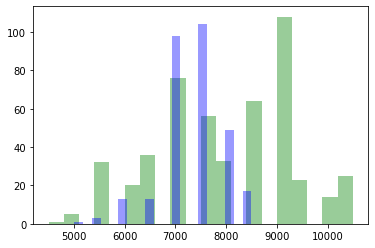

In [224]:
#sns.distplot(np.concatenate((echo_topihmask, echo_topihmask2)),bins=20, norm_hist=False, kde=False)
sns.distplot(echo_topihmask,bins=20, norm_hist=False, kde=False,color='g')
sns.distplot(echo_topihmask2,bins=20, norm_hist=False, kde=False,color='b')
plt.show()

In [203]:
closest_degree,closest_degreeindex = [],[]
for i in range(len(zdrkdp_xdist)):
    if np.isnan(zdrkdp_xdist[i]).all():
        closest_degree.append(np.nan)
        closest_degreeindex.append(np.nan)
    else:
        tmp = np.degrees(np.arctan2((zdrkdp_ydist[i]),(zdrkdp_xdist[i])))
        for j in range(len(dist_vect[i])):
            if dist_vect[i][j]>25:
                tmp[j]=np.nan
            else:
                continue
        closest_degree.append(tmp[np.nanargmin(np.abs(np.abs(tmp)-np.abs(np.degrees(storm_moang))))])
        closest_degreeindex.append(np.nanargmin(np.abs(np.abs(tmp)-np.abs(np.degrees(storm_moang)))))

In [204]:
dist_withangle=[]
for i in range(len(closest_degreeindex)):
    if np.isnan(closest_degreeindex[i]):
        dist_withangle.append(np.nan)
    else:
        obj = dist_vect[i]
        dist_withangle.append(obj[closest_degreeindex[i]])

In [205]:
np.nanmedian(dist_withangle),np.nanmedian([np.min(obj) for obj in dist_vect])

(13.6360923592969, 11.053300934821557)

In [208]:
#min_dist = []
#for objz in centroid_obj:
#    tmp = [((obj.xy[1][0]-objz.xy[1][0])**2+(obj.xy[0][0]-objz.xy[0][0])**2)**(0.5) for obj in centroid_objkdp]
#    tmpM = np.min(tmp)
#    min_dist.append(tmpM)
min_dist = []
for objz in centroid_obj:
    tmp = [((obj.xy[1][0]-objz.xy[1][0])**2+(obj.xy[0][0]-objz.xy[0][0])**2)**(0.5) for obj in centroid_objkdp]
    if any(element<12 for element in tmp):
        tmpM = np.min(tmp)
        min_dist.append(tmpM)
    else:
        min_dist.append(np.nan)
np.nanmedian(np.asarray(min_dist))

3.9132658020491737

8:2.93,9:2.99,12:3.05,15:3.70,19:4.94

### Echo Top Height

In [3]:
from copy import deepcopy
convstrat = xarray.open_dataset('/scra6/ft21894/radartrunk/0617/KUEX_20150617060123_20150617085533_convstrat.nc')
eclass = convstrat['steiner_eclass'][19,:,:]
ref = []
for i in range(38):
    print(i)
    base = pyart.io.read_grid(radargridlist[i])
    ref.append(deepcopy(base.fields['reflectivity']['data'][:,:,:]))
    del base
#eclass3d = np.zeros_like(ref)
#for i in range(41):
#    eclass3d[i,:,:] = eclass
#ref[eclass3d<2]=np.nan
#ref[ref<20] = np.nan

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


In [4]:
eclass3d = []
for j in range(38):
    tmp = convstrat['steiner_eclass'][j,:,:]
    eclass3d.append(np.broadcast_to(tmp, (41, *tmp.shape)))

In [5]:
refc = deepcopy(ref)
for i in range(38):
    refc[i][eclass3d[i]<2]=-9999
    refc[i][refc[i]<15] = -9999

In [6]:
base = pyart.io.read_grid(radargridlist[0])

In [106]:
from numba import njit
@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx

In [142]:
index(np.asarray(refc[0][:,150,100]),np.nan)

In [10]:
base = pyart.io.read_grid(radargridlist[0])

def echo_top_index(array=None,sizearray=refc[0][0,:,:]):
    echo_top = np.zeros_like(refc[0][0,:,:])
    for i in range(sizearray.shape[0]):
        for j in range(sizearray.shape[1]):
            tmp = np.asarray(array[:,i,j])
            if all(np.isnan(tmp)) is True:
                echo_top[i,j] = np.nan
            #echo_top[i,j] = np.min(np.where(np.isnan(array[:,i,j])))-1
            else:
                echo_top[i,j] = \
                next((idx for idx, val in np.ndenumerate(np.asarray(tmp)) if val==-9999),0)[0]
    return echo_top

def echo_top_h(index=None,height=None,sizearray=eclass3d_tmp[0]):
    echo_toph = np.zeros_like(sizearray)
    for i in range(sizearray.shape[0]):
        for j in range(sizearray.shape[1]):
            tmp=index[i,j]
            if np.isnan(tmp):
                echo_toph[i,j] = np.nan
            else:
                echo_toph[i,j] = base.z['data'][int(tmp)]

In [ ]:
def echo_top_h(index=None,height=None,sizearray=eclass3d_tmp[0]):
    echo_toph = np.zeros_like(sizearray)
    for i in range(sizearray.shape[0]):
        for j in range(sizearray.shape[1]):
            tmp=index[i,j]
            if np.isnan(tmp):
                echo_toph[i,j] = np.nan
            else:
                echo_toph[i,j] = base.z['data'][int(tmp)]

In [11]:
from tqdm import tqdm
echo_topi = []
for i in (range(38)):
    print(i)
    echo_topi.append(echo_top_index(refc[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


In [ ]:
echo_toph = []
for i in range(38):
    echo_toph.append(echo_top_h(echo_topi[i],base.z['data']))

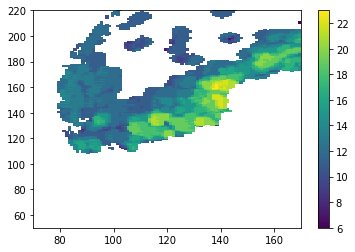

In [12]:
plt.pcolormesh(np.ma.masked_equal(echo_topi[7][:,:],0))
plt.colorbar()
plt.ylim(50,220)
plt.xlim(70,170)
plt.show()

In [39]:
time_echotih = np.zeros(38)
for i in range(38):
    echo_topic = np.asarray(deepcopy(echo_topi[i]))
    echo_topic[echo_topic<13] = np.nan
    tmp = np.nanpercentile(echo_topic,80)
    del echo_topic
    time_echotih[i] = base.z['data'][int(tmp)]

NameError: name 'deepcopy' is not defined

In [257]:
time_echotih

array([7500., 8000., 7500., 7500., 8000., 7500., 8000., 7500., 7500.,
       7500., 7500., 8000., 7500., 7500., 7500., 7500., 7000., 7500.,
       7500., 7000., 7000., 7000., 7000., 7000., 7000., 6500., 7000.,
       7000., 7000., 7000., 7000., 7000., 7000., 7000., 7000., 7000.,
       6500., 6500.])

In [255]:
base.z['data'][13]

6500.0